# Práctica 4 - Filtrado de Spam usando Bayes Ingenuo

Guarda una copia de este cuaderno en tu Google Drive para poder editarla y ejecutarla.

El propio cuaderno será tu informe de la práctica. Puedes añadir tantas secciones de código y de texto como consideres necesario para resolver todos los ejercicios propuestos y analizar los resultados obtenidos. Una vez hayas terminado, descarga el notebook en formato ipynb y súbelo a Moodle en la tarea habilitada para la P4 con el nombre NIP_P4.ipynb

Imports necesarios para ejecutar la práctica

In [2]:
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import KFold

Carga del fichero ZIP con todos los correos

In [3]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hYha8kSpbAhGIHAfygLFmGHIzHGAK5f8' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hYha8kSpbAhGIHAfygLFmGHIzHGAK5f8" -O "enron.zip" && rm -rf /tmp/cookies.txt
!unzip "enron.zip"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: enron6/ham/4072.2001-07-30.lokay.ham.txt  
  inflating: enron6/ham/4073.2001-07-31.lokay.ham.txt  
  inflating: enron6/ham/4079.2001-07-31.lokay.ham.txt  
  inflating: enron6/ham/4081.2001-08-01.lokay.ham.txt  
  inflating: enron6/ham/4084.2001-08-01.lokay.ham.txt  
  inflating: enron6/ham/4089.2001-08-01.lokay.ham.txt  
  inflating: enron6/ham/4096.2001-08-01.lokay.ham.txt  
  inflating: enron6/ham/4100.2001-08-01.lokay.ham.txt  
  inflating: enron6/ham/4102.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4104.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4106.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4108.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4110.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4115.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4118.2001-08-02.lokay.ham.txt  
  inflating: enron6/ham/4121.2001-08-03.lokay.ham.txt  
  inflating: enron6/ham/4125.2001-08-03.lok

Lectura de los emails y carga en las estructuras de datos

In [4]:
def read_folder(folder):
    mails = []
    file_list = glob.glob(folder)  # List mails in folder
    num_files = len(file_list)
    for i in range(0, num_files):
        i_path = file_list[i]
        i_file = open(i_path, 'rb')
        i_str = i_file.read()
        i_text = i_str.decode('utf-8', errors='ignore')  # Convert to Unicode
        mails.append(i_text)  # Append to the mail structure
        i_file.close()
    return mails

def load_enron_folders(datasets):
    path = './'
    ham = []
    spam = []
    for j in datasets:
        ham  = ham  + read_folder(path + '/enron' + str(j) + '/ham/*.txt')
        spam = spam + read_folder(path + '/enron' + str(j) + '/spam/*.txt')
    num_ham  = len(ham)
    num_spam = len(spam)
    print("mails:", num_ham+num_spam)
    print("ham  :", num_ham)
    print("spam :", num_spam)

    mails = ham + spam
    labels = [0]*num_ham + [1]*num_spam
    mails, labels = shuffle(mails, labels, random_state=0)
    return mails, labels

print("Loading files...")

print("--------------Loading train data---------------")
mails, y = load_enron_folders([1,2,3,4])

print("--------------Loading validation data----------")
mails_validation, y_validacion = load_enron_folders([5])

print("--------------Loading Test data----------------")
mails_test, y_test = load_enron_folders([6])

Loading files...
--------------Loading train data---------------
mails: 22541
ham  : 13545
spam : 8996
--------------Loading validation data----------
mails: 5175
ham  : 1500
spam : 3675
--------------Loading Test data----------------
mails: 6000
ham  : 1500
spam : 4500


Código para generar una bolsa de palabras que cuenta el número de apariciones de cada palabra en la lista de correos

Crea una matriz X con tantas filas como correos (27716) y tantas columnas como palabras de la BD. El elemento (i,j) de la matriz contiene el número de ocurrencias de la palabra j en el correo i

In [5]:
vectorizer  = CountVectorizer(ngram_range=(1, 1))  # Instancia de bolsa de palabras con palabras individuales como características
X = vectorizer.fit_transform(mails)                # Generación y cálculo de la bolsa de palabras en base a los datos de entrenamiento
X_validacion = vectorizer.transform(mails_validation) # Generación y cálculo de la bolsa de palabras en base a los datos de validación
X_test = vectorizer.transform(mails_test)          # Cáclulo de la bolsa de palabras con los datos de test

Aprendizaje de las probabilidades utilizando un modelo de distribución Bernoulli.

Consulta la documentación de sklearn para entender los parámetros.

In [6]:
classifier = BernoulliNB(alpha=1.0, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier.fit(X,y) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

BernoulliNB()

Cálculo de métricas del clasificador utilizando los datos de validación.

F1-score of the test:  97.50%
Confusion Matrix:
[[1484   16]
 [ 164 3511]]


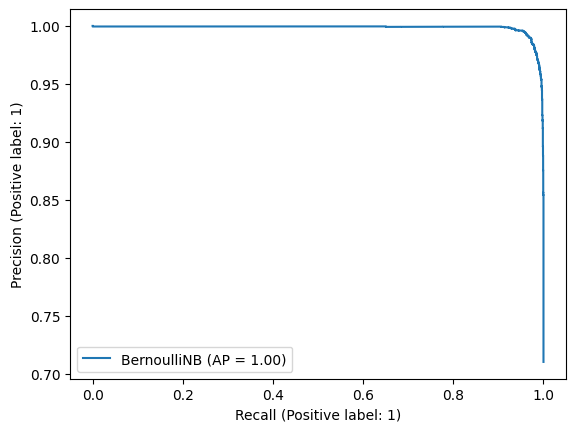

In [7]:
y_pred = classifier.predict(X_validacion)
f1_score=metrics.f1_score(y_validacion, y_pred)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score, '%' ))
C=metrics.confusion_matrix(y_validacion, y_pred)
print("Confusion Matrix:")
print(C)
metrics.PrecisionRecallDisplay.from_estimator(classifier,X_validacion, y_validacion)

Cálculo de métricas del clasificador utilizando los datos de test.

F1-score of the test:  98.44%
Confusion Matrix:
[[1465   35]
 [ 104 4396]]


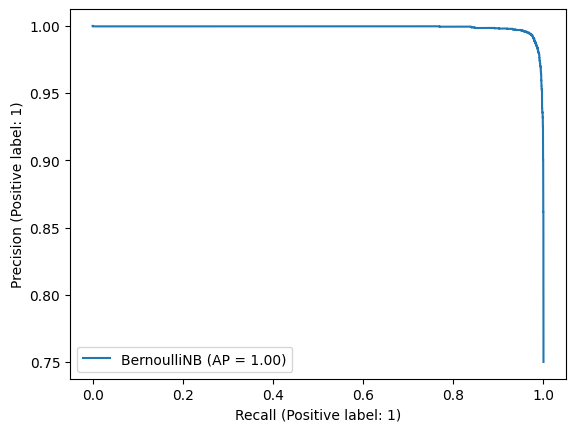

In [8]:
y_pred = classifier.predict(X_test)
f1_score=metrics.f1_score(y_test, y_pred)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score, '%' ))
C=metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(C)
metrics.PrecisionRecallDisplay.from_estimator(classifier,X_test, y_test)

Multinomial

In [9]:
classifier = MultinomialNB(alpha=0.015, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Multinomial
classifier.fit(X,y) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa

MultinomialNB(alpha=0.015)

Cálculo de métricas del clasificador utilizando los datos de validación

F1-score of the test:  99.20%
Confusion Matrix:
[[1474   26]
 [  33 3642]]


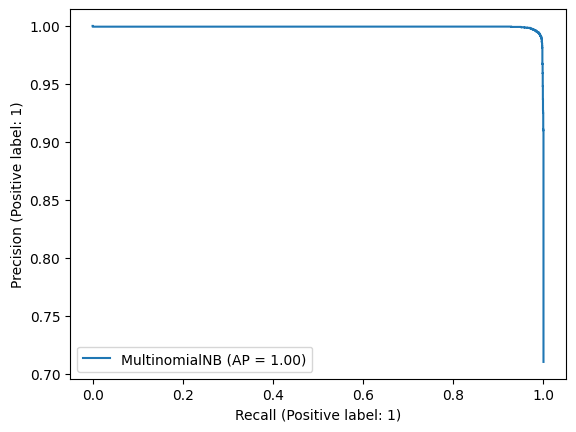

In [10]:
y_pred = classifier.predict(X_validacion)
f1_score=metrics.f1_score(y_validacion, y_pred)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score, '%' ))
C=metrics.confusion_matrix(y_validacion, y_pred)
print("Confusion Matrix:")
print(C)
metrics.PrecisionRecallDisplay.from_estimator(classifier,X_validacion, y_validacion)

Cálculo de métricas del clasificador utilizando los datos de test

F1-score of the test:  98.90%
Confusion Matrix:
[[1451   49]
 [  50 4450]]


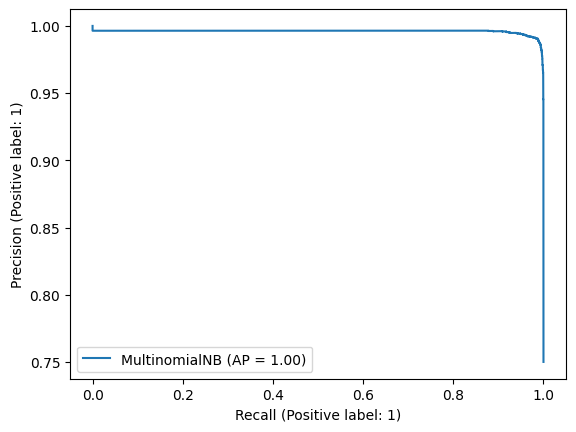

In [11]:
y_pred = classifier.predict(X_test)
f1_score=metrics.f1_score(y_test, y_pred)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score, '%' ))
C=metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(C)
metrics.PrecisionRecallDisplay.from_estimator(classifier,X_test, y_test)

Pruebas bernulli (palabras individuales y bi-gramas)

Solo palabras (ya testeado arriba pero es para tenerlo todo junto y con el alpha más óptimo):

In [12]:
vectorizer  = CountVectorizer(ngram_range=(1, 1))
X = vectorizer.fit_transform(mails)                # Generación y cálculo de la bolsa de palabras en base a los datos de entrenamiento
X_validacion = vectorizer.transform(mails_validation) # Generación y cálculo de la bolsa de palabras en base a los datos de validación
X_test = vectorizer.transform(mails_test)          # Cáclulo de la bolsa de palabras con los datos de test
classifier = BernoulliNB(alpha=0.01, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier.fit(X,y) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa
y_pred = classifier.predict(X_validacion)
f1_score=metrics.f1_score(y_validacion, y_pred)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score, '%' ))
C=metrics.confusion_matrix(y_validacion, y_pred)
print("Confusion Matrix:")
print(C)

F1-score of the test:  98.52%
Confusion Matrix:
[[1462   38]
 [  70 3605]]


Solo bi-gramas:

In [13]:
vectorizer  = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(mails)                # Generación y cálculo de la bolsa de palabras en base a los datos de entrenamiento
X_validacion = vectorizer.transform(mails_validation) # Generación y cálculo de la bolsa de palabras en base a los datos de validación
X_test = vectorizer.transform(mails_test)          # Cáclulo de la bolsa de palabras con los datos de test
classifier = BernoulliNB(alpha=1.08, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier.fit(X,y) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa
y_pred = classifier.predict(X_validacion)
f1_score=metrics.f1_score(y_validacion, y_pred)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score, '%' ))
C=metrics.confusion_matrix(y_validacion, y_pred)
print("Confusion Matrix:")
print(C)

F1-score of the test:  99.05%
Confusion Matrix:
[[1494    6]
 [  63 3612]]


Bi-gramas + palabras individuales:

In [14]:
vectorizer  = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(mails)                # Generación y cálculo de la bolsa de palabras en base a los datos de entrenamiento
X_validacion = vectorizer.transform(mails_validation) # Generación y cálculo de la bolsa de palabras en base a los datos de validación
X_test = vectorizer.transform(mails_test)          # Cáclulo de la bolsa de palabras con los datos de test
classifier = BernoulliNB(alpha=1.02, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier.fit(X,y) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa
y_pred = classifier.predict(X_validacion)
f1_score=metrics.f1_score(y_validacion, y_pred)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score, '%' ))
C=metrics.confusion_matrix(y_validacion, y_pred)
print("Confusion Matrix:")
print(C)

F1-score of the test:  99.10%
Confusion Matrix:
[[1485   15]
 [  51 3624]]


Pruebas multinomial (palabras individuales y bi-gramas)

Solo palabras (ya testeado arriba pero es para tenerlo todo junto y con el alpha más óptimo):

In [15]:
vectorizer  = CountVectorizer(ngram_range=(1, 1))
X = vectorizer.fit_transform(mails)                # Generación y cálculo de la bolsa de palabras en base a los datos de entrenamiento
X_validacion = vectorizer.transform(mails_validation) # Generación y cálculo de la bolsa de palabras en base a los datos de validación
X_test = vectorizer.transform(mails_test)          # Cáclulo de la bolsa de palabras con los datos de test
classifier = MultinomialNB(alpha=0.01, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier.fit(X,y) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa
y_pred = classifier.predict(X_validacion)
f1_score=metrics.f1_score(y_validacion, y_pred)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score, '%' ))
C=metrics.confusion_matrix(y_validacion, y_pred)
print("Confusion Matrix:")
print(C)

F1-score of the test:  99.18%
Confusion Matrix:
[[1474   26]
 [  34 3641]]


Solo bi-gramas:

In [16]:
vectorizer  = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(mails)                # Generación y cálculo de la bolsa de palabras en base a los datos de entrenamiento
X_validacion = vectorizer.transform(mails_validation) # Generación y cálculo de la bolsa de palabras en base a los datos de validación
X_test = vectorizer.transform(mails_test)          # Cáclulo de la bolsa de palabras con los datos de test
classifier = MultinomialNB(alpha=0.05, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier.fit(X,y) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa
y_pred = classifier.predict(X_validacion)
f1_score=metrics.f1_score(y_validacion, y_pred)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score, '%' ))
C=metrics.confusion_matrix(y_validacion, y_pred)
print("Confusion Matrix:")
print(C)

F1-score of the test:  99.36%
Confusion Matrix:
[[1496    4]
 [  43 3632]]


Bi-gramas + palabras individuales:

In [17]:
vectorizer  = CountVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(mails)                # Generación y cálculo de la bolsa de palabras en base a los datos de entrenamiento
X_validacion = vectorizer.transform(mails_validation) # Generación y cálculo de la bolsa de palabras en base a los datos de validación
X_test = vectorizer.transform(mails_test)          # Cáclulo de la bolsa de palabras con los datos de test
classifier = MultinomialNB(alpha=0.03, fit_prior=True, class_prior=None) # Instancia de clasificador de Bayes Ingenuo con distribución de Bernoulli
classifier.fit(X,y) # Cálculo de las probabilidades asociadas a cada palabra de la bolsa
y_pred = classifier.predict(X_validacion)
f1_score=metrics.f1_score(y_validacion, y_pred)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score, '%' ))
C=metrics.confusion_matrix(y_validacion, y_pred)
print("Confusion Matrix:")
print(C)

F1-score of the test:  99.55%
Confusion Matrix:
[[1494    6]
 [  27 3648]]


Resultados de las pruebas y conclusión del ganador:

Tras haber realizado múltiples experimentos de estimación de los alfas, en cada prueba se ha logrado encontrar aquel que está en el maximo absoluto de la curva y por tanto el que da como resultado una mayor eficiencia. Además era necesario experimentar con los distintos alfas en cada prueba, ya que para la que alguno era el más óptimo, para otra distinta no estaba ni cerca, con lo cual con ir poniendo números aleatorios como intervalo e ir estrechando la búsqueda entre ese intervalo es algo que se ha realizado en los 6 casos distintos.

***Bernulli***

-Solo palabras (alfa del 0.01%) -> 98.52%

-Solo bi-gramas (alfa del 1.08%) -> 99.05%

-Palabras + bi-gramas (alfa del 1.02%) -> 99.10%

***Multinomial***

-Solo palabras (alfa del 0.01%) -> 99.18%

-Solo bi-gramas (alfa del 0.05%) -> 99.36%

-Palabras + bi-gramas (alfa del 0.03%) -> 99.55%

Conclusión:

Si bien es cierto que la diferencia es mínima siendo del caso peor con el caso mejor del 1%, el resto de casos apenas se llevan décimas unos con otros, con lo cual ambos son bastante óptimos para la tarea, sin embargo el claro ganador de las pruebas sería la multinomial usando palabras con bi-gramas y un alfa del 0.03%. Si bien es cierto que podría existir algún alfa que ponga a otro como ganador, yo no lo he encontrado estrechando la búsqueda con lo cual puedo casi garantizar que este es el mejor método de todos siempre y cuando se aplique este alfa.

Evaluación del mejor clasificador:

Ahora que ya sabemos cuales son los parámetros para conseguir el mayor rendimiento en la clasificación de datos, vamos a ponerlo a prueba con los datos test que se nos han dado.

Para ello el clasificador tendrá una probabilidad umbral de spam y si el archivo la supera, será clasificado como tal. Este umbral es del 50% y además debemos reducir el recall para reducir los números de falsos negativos, pero manteniendo equilibrio con la precisión, para no dar muchos falsos positivos.

In [18]:
y_pred = classifier.predict_proba(X_test)
pred = []

for i in range(len(y_pred)):
  if y_pred[i][1] > 0.01:
    pred.append(1)
  else:
    pred.append(0)

f1_score=metrics.f1_score(y_test, pred)
print('%s %2.2f%s' % ('F1-score of the test: ', 100*f1_score, '%' ))

C=metrics.confusion_matrix(y_test, pred)
print("Confusion Matrix:")
print(C)

acc=metrics.accuracy_score(y_test, pred)
precision=metrics.precision_score(y_test, pred)
recall=metrics.recall_score(y_test, pred)

print('%s %2.8f' % ('Accuracy: ', acc))
print('%s %2.8f' % ('Precision: ', precision))
print('%s %2.8f' % ('Recall: ', recall))

F1-score of the test:  99.27%
Confusion Matrix:
[[1466   34]
 [  32 4468]]
Accuracy:  0.98900000
Precision:  0.99244780
Recall:  0.99288889


Como se aprecia en los resultados y tras varias pruebas concluyo que el mejor umbral es del 1%  ya que se obtienen 34 falsos positivos y 32 falsos negativos en vez de 32 y 47 por lo que hemos bajado sobretodo los falsos negativos, además de obtener mejor F1. Los valores de recall y precision están bastante parejos con un 99,2% y accuracy posee un 98,9%

Correos con correcto e incorrecto análisis.

Un verdadero positivo se refiere a un correo spam clasificado correctamente.
Un falso positivo se refiere a un correo ham clasificado incorrectamente.
Un verdadero negativo se refiere a un correo ham clasificado correctamente.
Un falso negativo se refiere a un correo spam clasificado incorrectamente


Verdadero positivo:

In [23]:
for i in range(len(mails_test)):
  if y_test[i] == 1 and pred[i] == 1:
    Verdadero_Positivo, Verdadero_Positivo_i = mails_test[i], i
    break

print("Ejemplo de verdadero positivo, encontrado en la componente %d:\n\n%s" % (Verdadero_Positivo_i, Verdadero_Positivo))

Ejemplo de verdadero positivo, encontrado en la componente 0:

Subject: re : [ humidified ] 61 % - off vicodin . synthetic reachability
avocado correspondence blanchard finnegan
goblins shrinkable prodigally gospels
regressive budgets vreeland adequately
prosecuting release but
assemblies atemporal enumerated
somewhere want affable
circularly pent bedtime pragmatically
amnesty seer gird
reabbreviates coops headlands
- -
phone : 627 - 971 - 1286
mobile : 753 - 945 - 1416
email : laurine . jackson 2002 @ wanadoo . fr



Falso positivo:

In [24]:
for i in range(len(mails_test)):
  if y_test[i] == 0 and pred[i] == 1:
    Falso_Positivo, Falso_Positivo_i = mails_test[i], i
    break

print("Ejemplo de falso positivo, encontrado en la componente %d:\n\n%s" % (Falso_Positivo_i, Falso_Positivo))

Ejemplo de falso positivo, encontrado en la componente 204:

Subject: it ' s not the same without your smiling face ! ! ! ! ! !
i hope all is well for you and your family . . . . how is that precious daughter
of yours ? i bet meghan is really growing ! ! ( sorry , i probably mispelled
her name )
we miss you very much but so glad you found a new " home " . . . . . ( ie work place )
i wanted to drop a line and say hello . . . . .
i ' m enjoying working at campus . it ' s very nice being close to home and my
son ' s school .
take care ,
sharee


Verdadero negativo:

In [26]:
for i in range(len(mails_test)):
  if y_test[i] == 0 and pred[i] == 0:
    Verdadero_Negativo, Verdadero_Negativo_i = mails_test[i], i
    break

print("Ejemplo de verdadero negativo, encontrado en la componente %d:\n\n%s" % (Verdadero_Negativo_i, Verdadero_Negativo))

Ejemplo de verdadero negativo, encontrado en la componente 3:

Subject: tw imbalances 12 / 11
receivable balances needing attention :
el paso
pg & e
ngpl
mojave
payable balances needing attention :
eog
pan - alberta
agave


Falso negativo:

In [27]:
for i in range(len(mails_test)):
  if y_test[i] == 1 and pred[i] == 0:
    Falso_Negativo, Falso_Negativo_i = mails_test[i], i
    break

print("Ejemplo de falso negativo, encontrado en la componente %d:\n\n%s" % (Falso_Negativo_i, Falso_Negativo))

Ejemplo de falso negativo, encontrado en la componente 95:

Subject: seven day cruise for two with any closed loan !
downs financial inc . 88 steele street , suite 400 denver , co 80206

